### Required imports

In [1]:
from sklearn.datasets import load_files

import numpy as np

import re

from supporting_modules.text_cleaning import PATTERNS
import supporting_modules.text_cleaning as stc
import supporting_modules.data_visualization as sdv

## Load data from dataset

Firstly, we need to load the dataset for further analysis. In this case, it will be the dataset named **"Large Movie Review Dataset"**. It is downloaded from https://ai.stanford.edu/~amaas/data/sentiment/

The sentiment values in the text corpus from Stanford Dataset is either positive or negative. More info about these data is in `README` file. After loading, the data is of sklearn Bunch type, so we have to retrieve list of text data and numpy.ndarray with the labels.

In [2]:
train_data = load_files("../datasets/aclImdb_v1/aclImdb/train")
test_data = load_files("../datasets/aclImdb_v1/aclImdb/test")

reviews_train, y_train = train_data.data, train_data.target
reviews_test, y_test = test_data.data, test_data.target

The types of each data element are listed below. As we can see the data are saved as bytes. The length of the training data set is equal to 75,000. In the README file, it was mentioned that the quantity of positive and negative reviews is equal to 50,000 (per 25,000 in training and test part accordingly). The difference equal to 50,000 is caused by data labeled as 'unsup'. This part of the data includes an additional 50,000 unlabeled documents for unsupervised learning.

In the first part of the project, this data will not be needed. Therefore, they will be subtracted from the training pool (there is no data with this label in the test pool).

In [3]:
print(f"train_data data type: {type(train_data)}")
print(f"reviews_train type: {type(reviews_train)}")
print(f"the type of single review: {type(reviews_train[0])}")
print(f"reviews_test type: {type(reviews_test)}")
print(f"text_train data length: {len(reviews_train)}")
print(f"text_test data length: {len(reviews_test)}")

train_data data type: <class 'sklearn.utils._bunch.Bunch'>
reviews_train type: <class 'list'>
the type of single review: <class 'bytes'>
reviews_test type: <class 'list'>
text_train data length: 75000
text_test data length: 25000


In [4]:
# The data in the training set are distributed in the proportions of 12500, 12500, 50000
# In next steps I remove those items that are 'unsup' 

print(f"The proportions of the data distribution: {np.bincount(y_train)}")
print(f"Numeric values of labels: {np.unique(y_train, return_counts=True)}")
print(f"Label names: {train_data.target_names}\n")

print(f"The proportions of the data distribution: {np.bincount(y_test)}")
print(f"Numeric values of labels: {np.unique(y_test, return_counts=True)}")
print(f"Label names: {test_data.target_names}\n")

The proportions of the data distribution: [12500 12500 50000]
Numeric values of labels: (array([0, 1, 2]), array([12500, 12500, 50000], dtype=int64))
Label names: ['neg', 'pos', 'unsup']

The proportions of the data distribution: [12500 12500]
Numeric values of labels: (array([0, 1]), array([12500, 12500], dtype=int64))
Label names: ['neg', 'pos']



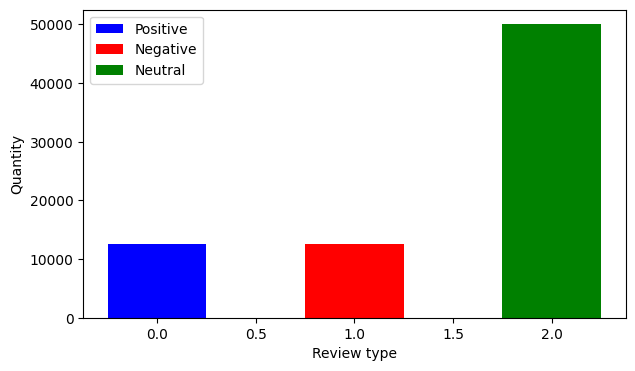

In [5]:
sdv.count_per_label(np.bincount(y_train), ('Positive', 'Negative', 'Neutral'))

In [6]:
# lets see how the reviews looks like

print("POSITIVE REVIEW EXAMPLE:\n".upper(), reviews_train[3], "\n\n", "*" * 100, "\n")
print("NEGATIVE REVIEW EXAMPLE:\n", reviews_train[126])

POSITIVE REVIEW EXAMPLE:
 b"Dan Katzir has produced a wonderful film that takes us on a roller-coaster ride through a real romance set in the troubles surrounding modern Israel.<br /><br />For anyone who's ever been in love, the film brings back the uncertainties, the insecurities and heartache that make love so bitter-sweet. The atmosphere of fear and isolation that came with the difficult times in Israel at that time just serve to intensify the feeling. Instantly, you are drawn in to Dan's plight, and you can't fail to be deeply moved.<br /><br />You can't write drama and passion like this - the contrast between the realities of Dan's desperate, snatched relationship with Iris, and the realities of a state in turmoil make this eminently watchable. If you have an ounce of passion, and have ever been in love, see this film." 

 **************************************************************************************************** 

NEGATIVE REVIEW EXAMPLE:
 b"This film comes as the ultima

## Remove the data without labels

The data are cleaned using function defined in `additional_modules/test_cleaning`. 

After this action we'll have balanced binary data in both datasets (training and test). The data after applying stc.clear_reviews_from_dataset() function looks like:

In [7]:
reviews_train_binary, y_train_binary = stc.clear_reviews_from_dataset(y_train, reviews_train)

In [8]:
# Our data after applying stc.clear_reviews_from_dataset() function

print(f"The proportions of the data distribution: {np.bincount(y_train_binary)}")
print(f"Numeric values of labels: {np.unique(y_train_binary, return_counts=True)}")

The proportions of the data distribution: [12500 12500]
Numeric values of labels: (array([0, 1]), array([12500, 12500], dtype=int64))


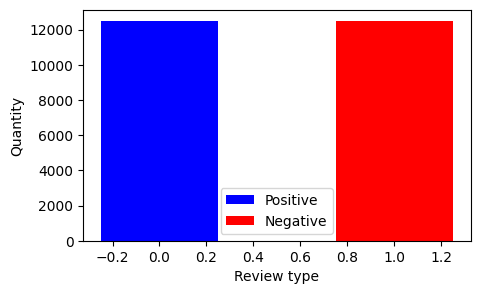

In [9]:
sdv.count_per_label(np.bincount(y_train_binary), ('Positive', 'Negative', 'Neutral'))

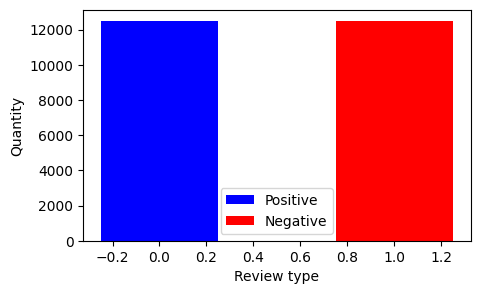

In [10]:
sdv.count_per_label(np.bincount(y_test), ('Positive', 'Negative', 'Neutral'))

Unique reviews in the both datastes:

In [11]:
len(set(reviews_train_binary)), len(reviews_train_binary)

(24904, 25000)

In [12]:
len(set(reviews_test)), len(reviews_test)

(24801, 25000)

### Word quantity per review histograms

Below there are the histograms for data before text cleaning. The most common length of reviews  is between (more-less) 70 and 700 words per text in both parts (train and test). In the next steps, the documents will be cleaned so these values will be decreased. 

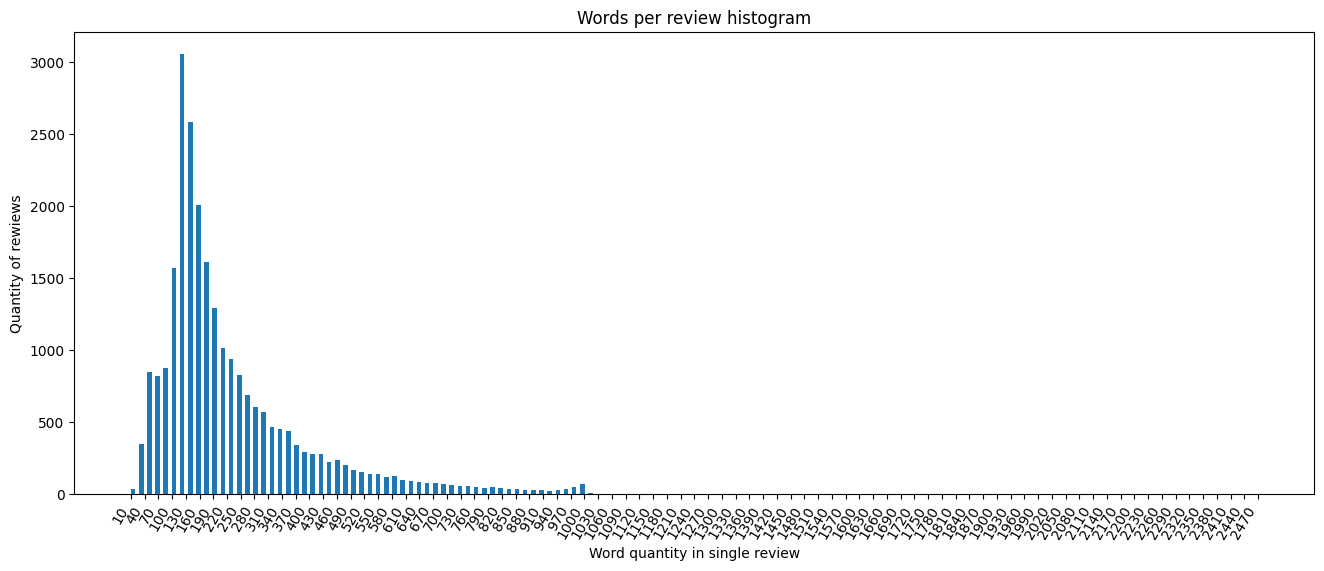

In [13]:
word_counts = sdv.make_count_histogram(reviews_train_binary, 30)

In [14]:
# Two the shortest reviews in our train dataset

for text in reviews_train_binary:
    if len(text.split()) <= min(list(word_counts.keys())):
        print(text)

b"I wouldn't rent this one even on dollar rental night."
b'This movie is terrible but it has some good effects.'


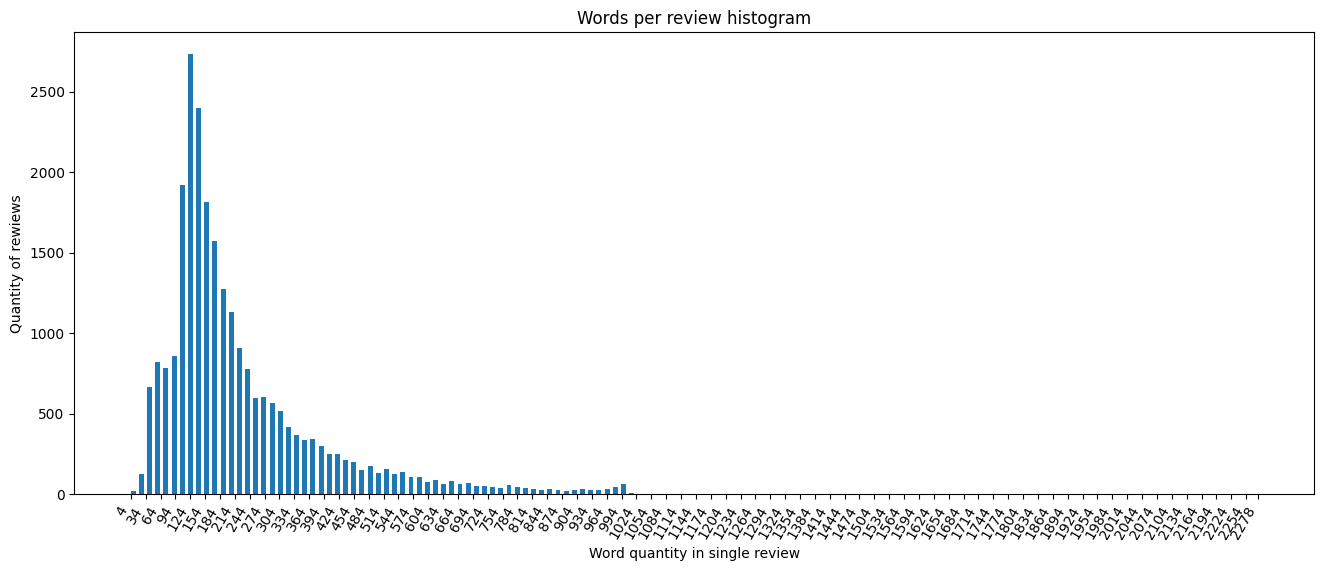

In [15]:
word_counts = sdv.make_count_histogram(reviews_test, 30)

In [16]:
# Two the shortest reviews in our test dataset

for text in reviews_test:
    if len(text.split()) <= min(list(word_counts.keys())):
        print(text)

b'Primary plot!Primary direction!Poor interpretation.'


## Text data cleaning

### Checking if the text contains html tags

 Let's check if there are any HTML tags in our reviews and if so let's take a look at what they look like.
The checking is made using the function **`get_occurance_in_dataset()`** defined in **`supporting_modules/text_cleaning`** (aliased as **`srt`** in this notebook). 
As it is visible below not all results are proper HTML tags some of them look like such elements but they aren't. For instance in the first returned we have open sign "<" directly behind this sign there's the space and the reguralar text data till the closing proper HTLM tag \<br /\> . Similar situation in the next three returned and the last one. The rest of returned values are proper or almost proper tags.

In [17]:
stc.get_occurance_in_dataset(reviews_train_binary)

{"< $600 per screen its opening weekend, and just over $400 each, after its month's theater run in latter 2002. Overall gross was $261K, which I'd doubt could cover cast and crew's hotel and food for a week on location.<br />",
 '< and make notes for my partial "review" to show how foolish the movie is. "Resident Evil" (horror) or "Dude, Where\'s My Car?" (comedy) I can watch over and over again and still enjoy! But this...!<br />',
 '< than 30 minutes of watching, being bored and irritated. <br />',
 '< who was to be a victim, but woman-power trumps evil scientist every time.<br />',
 '</SPOILER>',
 '</em>',
 '</i>',
 '<3 <br />',
 '<<<sigh>',
 '<=8.<br />',
 '<SPOILER>',
 '<br />',
 '<em>',
 '<grin>',
 '<hr>',
 '<http://rogerebert.suntimes.com/apps/pbcs.dll/section?category=ANSWERMAN>',
 '<i>',
 '<sp?) classic "Romeo & Juliet". Guess I\'ll have to rent that next.<br />'}

In the case of test reviews, all returned  tags could be removed in the next steps. Not all of them are HTML tags byt they rather won't be useful in further steps. An exception may be an item: '\<\< controversial.\<br /\>'. This one also should be cleaned.

In [18]:
# reviews_test
stc.get_occurance_in_dataset(reviews_test)

{'< Cough , cough >',
 '< Cough >',
 '< YES >',
 '<-----Minor Spoilers!----->',
 '<-----Minor Spoilers!---->',
 '<..>',
 '</i>',
 '<33<br />',
 '<< Review posted at FilmDailies.com>',
 '<< controversial.<br />',
 '<<<<< ......... ......... ........................ ................ ..................... .................. .............. ............ ................<br />',
 '<<<<<<br />',
 '<<<<<br />',
 '<br />',
 '<grin>',
 '<i>',
 '<p>'}

## Removal of html tags from the reviews

Before removing the html tags, problematic fragments found as tags but which are not - should be taken into attention. In order to remove such elements - the replacement "\<sp\\?\\)|< " by "" seems like a good idea - because we have in such cases either tags started with "\<" + space or "\<sp?)".

After removing them, only tags and tag-like elements that look redundant will remain in the documents. Then these elements will be repraced by blank string. 

Both activities are performed using function **`clear_substr_in_texts()`** defined in **`supporting_modules/text_cleaning`** (aliased as **`srt`** in this notebook). 



In [19]:
# remove tag-like elements from train data
reviews_train_binary = stc.clear_substr_in_texts(reviews_train_binary, \
                                                 pattern=re.compile(r"<sp\?\)|< "))

# show if tag-like element list looks ok
print("TAGS LEFT:")
print(stc.get_occurance_in_dataset(reviews_train_binary))


REMOVED SUBSTRINGS:
 {'<sp?)', '< '}
TAGS LEFT:
{'</i>', '<br />', '<<<sigh>', '<hr>', '<em>', '<i>', '<3 <br />', '<=8.<br />', '<http://rogerebert.suntimes.com/apps/pbcs.dll/section?category=ANSWERMAN>', '</em>', '<SPOILER>', '<grin>', '</SPOILER>'}


In [20]:
# remove tag-like elements from train data
reviews_test = stc.clear_substr_in_texts(reviews_test, \
                                                 pattern=re.compile(r"<< controversial"))

# show if tag-like element list looks ok
print("TAGS LEFT:")
print(stc.get_occurance_in_dataset(reviews_test))


REMOVED SUBSTRINGS:
 {'<< controversial'}
TAGS LEFT:
{'<p>', '<-----Minor Spoilers!----->', '<br />', '< Cough >', '<33<br />', '<..>', '<i>', '<<<<< ......... ......... ........................ ................ ..................... .................. .............. ............ ................<br />', '<< Review posted at FilmDailies.com>', '<-----Minor Spoilers!---->', '< YES >', '< Cough , cough >', '<<<<<br />', '<<<<<<br />', '<grin>', '</i>'}


#### Remove HTML tags from train and test data

Finally let's remove remaining tags and tags-like elements.

In [21]:
reviews_train_binary = stc.clear_substr_in_texts(reviews_train_binary, \
                                                 pattern=PATTERNS['html_tags'])

reviews_test = stc.clear_substr_in_texts(reviews_test, \
                                                 pattern=PATTERNS['html_tags'])
# show whether any tag-like elements remain
print("TAGS LEFT:")
stc.get_occurance_in_dataset(reviews_train_binary), stc.get_occurance_in_dataset(reviews_train_binary)


REMOVED SUBSTRINGS:
 {'</i>', '<br />', '<<<sigh>', '<hr>', '<em>', '<i>', '<3 <br />', '<=8.<br />', '<http://rogerebert.suntimes.com/apps/pbcs.dll/section?category=ANSWERMAN>', '</em>', '<SPOILER>', '<grin>', '</SPOILER>'}

REMOVED SUBSTRINGS:
 {'<p>', '<-----Minor Spoilers!----->', '<br />', '< Cough >', '<33<br />', '<..>', '<i>', '<<<<< ......... ......... ........................ ................ ..................... .................. .............. ............ ................<br />', '<< Review posted at FilmDailies.com>', '<-----Minor Spoilers!---->', '< YES >', '< Cough , cough >', '<<<<<br />', '<<<<<<br />', '<grin>', '</i>'}
TAGS LEFT:


(set(), set())

## Convert all letters to lowercase

In case of sentiment analysis in movie reviews convertion to the lowercase can be helpfull in the next steps like tokenization, stemming and so on. 

In [22]:
reviews_train_binary = [review.lower() for review in reviews_train_binary]
reviews_test = [review.lower() for review in reviews_test]

## Remove http addresses from review content

In order to deleting http links from review contents the same function as previously (**`clear_substr_in_texts()`**) will be used.

In [23]:
reviews_train_binary = stc.clear_substr_in_texts(reviews_train_binary, 
                                                 PATTERNS['http_addr'], "") 


REMOVED SUBSTRINGS:
 {'http://ferdinandvongalitzien.blogspot.com/', 'http://www.freedomofmind.com/resourcecenter/groups/t/tm/dissenter.htm)save', 'http://www.johntopping.com/harvey%20perr/war%20widow/war_widow.html', 'http://airwolf.org', 'http://pro.imdb.com/title/tt0059080/', 'http://imdb.com/mymovies/list?l=21849907average', 'http://www.imdb.com/title/tt0077247/.', 'http://rateyourmusic.com/collection/fedor8/', 'http://www.theindependent.com/twisters/', 'http://imdb.com/mymovies/list?l=21849889for', 'http://rateyourmusic.com/list/fedor8/150_worst_cases_of_nepotism/', 'http://en.wikipedia.org/wiki/intentional_fallacy', 'http://www.hbo.com/apps/schedule/', 'http://imdb.com/title/tt0250274/', 'http://www.intuitor.com/moviephysics/bleep.html', 'http://theoscarsblog.blogspot.com/2010/02/movie-review-secret-of-', 'http://rateyourmusic.com/', 'http://www.invocus.net)', 'http://imdb.com/title/tt0283181/the', 'http://www.dvdtalk.com/reviews/3199/thief-in-the-night-se-a/', 'http://www.gutenb

In [24]:
reviews_test = stc.clear_substr_in_texts(reviews_test, 
                                         PATTERNS['http_addr'], "") 


REMOVED SUBSTRINGS:
 {'http://ferdinandvongalitzien.blogspot.com/', 'http://without-terebi.blogspot.com/2009/08/thirst-aka-bakjwi.html', 'http://www.weatherpaparazzi.com/flooding.asp', 'http://www.youtube.com/watch?v=2-w7evbears', 'http://www.macrophile.com/', 'http://www.biz-community.com/article/196/97/5223.html', 'http://tinyurl.com/znyyqhuzzah!!', 'http://www.thepetitionsite.com', 'http://www.imdb.com/title/tt0060164/i', 'http://www.imdb.com/title/tt0115940/', 'http://www.razzies.com/history/05nomactr.asp)', 'http://imdb.com/title/tt0338095/', 'http://treasureflix.com', 'http://www.youtube.com/watch?v=kk0gtfuk98u).', 'http://www.taz.de/pt/2006/09/02/a0013.1/textdruck', 'http://www.imdb.com/title/tt0207805)', 'http://www.zonadvd.com', 'http://www.obsessedwithfilm.com/', 'http://en.wikipedia.org/wiki/palisades_nuclear_generating_station', 'http://moviemusereviews.blogspot.com', 'http://rateyourmusic.com/collection/fedor8/1please', 'http://www.imdb.com/title/tt0425350/', 'http://www.

## Email addresses in the corups

Now let's check if thre are any email addresses in our courpus (train and test). Such values (simiraly as the previously removed data) do not carry value related to feelings about the rated movies.

But as you can see not all walues that have the format similar to the email address is an email address indead. 

#### Check the train data

In [25]:
print(stc.get_occurance_in_dataset(reviews_train_binary, PATTERNS['email_addr']))

{'foxbarking@yahoo.com ', '"okul-d@bbe" ', 'iamaseal2@yahoo.com', 'tight-@ss ', 'bits@midohio.net(new ', 'f*@# ', 'f^@ks ', '*@$#', 's@#t ', 'albany234@googlemail.com', '$%&@ ', 'vannoord@let.rug.nlthe ', 'f@** ', '@#$0&%!!" ', '#@$%#@$ ', 'movie.deniselacey2000@yahoo.com', 's#@t. ', '$^@%. ', 'f#@%ing ', '(daneldorado@yahoo.com)', 'di@k ', 'f@ck ', '@#$%!???" ', '#%$@ers!!! ', '&*%#@#^ ', 'cartwrightbride@yahoo.com', 'f#@k ', 'f#@k!ng ', 'f@#king ', '(jpieczanski@sidwell.edu)', 'sh#¤@t!definitely ', '&^@_+#!* ', '(whiteflokati@hotmail.com)', 'mindf@ck ', '$*@(%& ', 'cr@p. ', 'bull!?#@ ', 'invinoveritas1@aol.com ', 'darkangel_1627@yahoo.com. ', 'w@nk. ', '@ ', '(bighouseaz@yahoo.com). ', '*@#% ', 'f@ckin ', '@*!^ ', 'dmd2222@verizon.net.i ', '%$@# ', 'deusexmachina529@aol.com', 'l.swanberg@yahoo.com', '"&$*@$ ', '@#%& ', 'horsecoach4hire@hotmail.com? ', 's@*t ', 'w@nk ', '@#$%." ', '"f@g-hag" ', '#@^!# ', 'tawnyteel@yahoo.com ', 'vannoord@let.rug.nl', 'co@k", ', 'dakota_loves_it@hot ',

#### Check the test data

In [26]:
print(stc.get_occurance_in_dataset(reviews_test, PATTERNS['email_addr']))

{'th@ ', 'd@mn ', 'viewers.requests@itv.com ', 'cristin6891@aim.com ', '@$$hole, ', 'iamaseal2@yahoo.com', 'it!@ ', "@&$%in' ", '!@$% ', '$%#@#$. ', 'f*@k ', '^%^%$^$#%@$#@ ', '@$#@#@. ', 'dumb@$$ ', '@the ', 'valid908@yahoo.com', '!^@@&*! ', 'wrp24@adelphia.net ', 'bad@$$ ', 'camera-man-must-be-sh%#@ing-his-pants ', 'girlygirl148@aol.com ', '!@#$ ', 'killer2511@hotmail.com', 'f@#$ ', '"tw@t" ', '$$$#@%@! ', '#$*@!!!!" ', 'thndrmouse@aol.com', 'john_simension@yahoo.com', 'hpn_x@hotmail.com ', 'f@rt,@ss, ', 'kk2840@earthlink.net ', 'fu#@ing ', 'atstone_stew@yahoo.co.uk ', 'ottenbreit2@netzero.net ', 'angelpuss924@yahoo.com ', 'cr@p. ', 'p@rn ', '@@', 'b*&%@#&s, ', 'tcampo23@aol.com', '@$$!what ', '@$$ ', '@ss. ', "kk2840@earthlink.nethere's ", 'noelgypsy@yahoo.com... ', 'emilyfussell@hotmail.com ', '*@#! ', 'cr@p ', '@ ', 'creator67@pipinternet.net, ', 's*%@ ', 'contact@fightrunner.co.uk', '@$$.', 'cr@pfest. ', 'yurets777@hotmail.com ', 'iloverot@aol.com', 'dvlbab300@aol.com ', 'cr@ppy 

## Email regex format in the corups - conclusion

Some of these strings that match the pattern that matches email addresses are actually disguised profanity. They certainly express emotions, but the percentage of such sequences in the entire corpus seems to be negligible.
The **`corpus_docs_word_frequency()`** defined in **`supporting_modules/text_cleaning`** module was used to check. 

For comparison, 3 lighter "obscene words" were checked also as you can see they occur in the corpus. So those filled with characters like "#%@$#@" we can rather remove. They will not significantly affect the representation of these words in the data (the actual words of this type will be leave alone :-) ). So those data will be removed from both corpuses. 

In [27]:
words_to_check = ('s#@t', 'di@k',  'bull!?#@')
words_to_check_2 = PATTERNS['obscene_words']

In [28]:
stc.corpus_docs_word_frequency(reviews_train_binary, words_to_check)

Word 's#@t' occurs 1 times in the corpus.
Word 's#@t' occurs in 1 documents.

Word 'di@k' occurs 1 times in the corpus.
Word 'di@k' occurs in 1 documents.

Word 'bull!?#@' occurs 1 times in the corpus.
Word 'bull!?#@' occurs in 1 documents.



In [29]:
stc.corpus_docs_word_frequency(reviews_train_binary, words_to_check_2)

Word 'sh#@%#' occurs 85 times in the corpus.
Word 'sh#@%#' occurs in 71 documents.

Word 'di#@%#' occurs 488 times in the corpus.
Word 'di#@%#' occurs in 331 documents.

Word 'bu#@%#' occurs 23 times in the corpus.
Word 'bu#@%#' occurs in 21 documents.



### Clear reviews from substrings that have format similar to the email


In [31]:
reviews_train_binary = stc.clear_substr_in_texts(reviews_train_binary, 
                                                 PATTERNS['email_addr'], "") 


REMOVED SUBSTRINGS:
 {'foxbarking@yahoo.com ', '"okul-d@bbe" ', 'iamaseal2@yahoo.com', 'tight-@ss ', 'bits@midohio.net(new ', 'f*@# ', 'f^@ks ', '*@$#', 's@#t ', 'albany234@googlemail.com', '$%&@ ', 'vannoord@let.rug.nlthe ', 'f@** ', '@#$0&%!!" ', '#@$%#@$ ', 'movie.deniselacey2000@yahoo.com', 's#@t. ', '$^@%. ', 'f#@%ing ', '(daneldorado@yahoo.com)', 'di@k ', 'f@ck ', '@#$%!???" ', '#%$@ers!!! ', '&*%#@#^ ', 'cartwrightbride@yahoo.com', 'f#@k ', 'f#@k!ng ', 'f@#king ', '(jpieczanski@sidwell.edu)', 'sh#¤@t!definitely ', '&^@_+#!* ', '(whiteflokati@hotmail.com)', 'mindf@ck ', '$*@(%& ', 'cr@p. ', 'bull!?#@ ', 'invinoveritas1@aol.com ', 'darkangel_1627@yahoo.com. ', 'w@nk. ', '@ ', '(bighouseaz@yahoo.com). ', '*@#% ', 'f@ckin ', '@*!^ ', 'dmd2222@verizon.net.i ', '%$@# ', 'deusexmachina529@aol.com', 'l.swanberg@yahoo.com', '"&$*@$ ', '@#%& ', 'horsecoach4hire@hotmail.com? ', 's@*t ', 'w@nk ', '@#$%." ', '"f@g-hag" ', '#@^!# ', 'tawnyteel@yahoo.com ', 'vannoord@let.rug.nl', 'co@k", ', '

In [32]:
reviews_test = stc.clear_substr_in_texts(reviews_test, 
                                                 PATTERNS['email_addr'], "") 


REMOVED SUBSTRINGS:
 {'th@ ', 'd@mn ', 'viewers.requests@itv.com ', 'cristin6891@aim.com ', '@$$hole, ', 'iamaseal2@yahoo.com', 'it!@ ', "@&$%in' ", '!@$% ', '$%#@#$. ', 'f*@k ', '^%^%$^$#%@$#@ ', '@$#@#@. ', 'dumb@$$ ', '@the ', 'valid908@yahoo.com', '!^@@&*! ', 'wrp24@adelphia.net ', 'bad@$$ ', 'camera-man-must-be-sh%#@ing-his-pants ', 'girlygirl148@aol.com ', '!@#$ ', 'killer2511@hotmail.com', 'f@#$ ', '"tw@t" ', '$$$#@%@! ', '#$*@!!!!" ', 'thndrmouse@aol.com', 'john_simension@yahoo.com', 'hpn_x@hotmail.com ', 'f@rt,@ss, ', 'kk2840@earthlink.net ', 'fu#@ing ', 'atstone_stew@yahoo.co.uk ', 'ottenbreit2@netzero.net ', 'angelpuss924@yahoo.com ', 'cr@p. ', 'p@rn ', '@@', 'b*&%@#&s, ', 'tcampo23@aol.com', '@$$!what ', '@$$ ', '@ss. ', "kk2840@earthlink.nethere's ", 'noelgypsy@yahoo.com... ', 'emilyfussell@hotmail.com ', '*@#! ', 'cr@p ', '@ ', 'creator67@pipinternet.net, ', 's*%@ ', 'contact@fightrunner.co.uk', '@$$.', 'cr@pfest. ', 'yurets777@hotmail.com ', 'iloverot@aol.com', 'dvlbab3

## Remove the digits

In this step substrings with digits inside will be removed, I mean the "words" like: "1994's ", 'messick.5 ', '11 ', 'match2) ', '1980s.the ' and dates and other numeric values.

In [50]:
reviews_train_binary = stc.clear_substr_in_texts(reviews_train_binary, 
                                                 PATTERNS['digits_in_substr'], "") 


REMOVED SUBSTRINGS:
 {'90`s.people ', '5.from ', 'ah56a ', "1994's ", '11 ', '1980s.the ', '51st ', '10x ', '1998), ', '75? ', '1-rating, ', 'no.1', '1977, ', '4f ', '10/15/03. ', 'f-11f ', '1972.worth ', 'runtime:106min ', '1900s, ', '666, ', 'with.3. ', '20/20 ', '1-0 ', '1965', '1944', 'seriously!.4/10. ', '1972', '0.5/10. ', '84)alice ', 'mst3k, ', '10/10!the ', '1974)groundbreaker ', '70s-amateur ', '0/5.0', '1953). ', '6)the ', '2003).as ', "80's/ ", '1995).as ', '230lbs ', '1960) ', '1947 ', '7! ', 'demise.1st ', '71, ', '3-4.the ', '2.35:1', 'k-911, ', "3000!'i ", 'r2d2 ', '2001-ish ', 'beer.3/10', '1st" ', '2/10p.s', "1965's", '666-piece ', '747. ', '80s! ', '1982...et ', 'sg1 ', '1547 ', '7ft ', '7.5/10santa ', '86 ', '1)several ', '1870s. ', "1937.i've ", '2004). ', '7.certainly, ', 'u2 ', 'c1 ', '250.runtime:88min ', '6,1 ', 'seen.8/10not ', '1994', 'p2p ', '21!) ', '17!" ', 'bbc2. ', 'cf-13s) ', 'thing.2/10', '1888), ', '1930-comedy). ', '128 ', '9-stars, ', '1976 ', "101

In [51]:
reviews_test = stc.clear_substr_in_texts(reviews_test, 
                                                 PATTERNS['digits_in_substr'], "") 


REMOVED SUBSTRINGS:
 {'1789. ', '1988-1993). ', '2--just ', "1994's ", 'messick.5 ', '11 ', 'match2) ', '1980s.the ', '51st ', '1998), ', '10x ', '75? ', 'no.1', '1977, ', 'later.8/10', "1987's", '1900s, ', '1946-48 ', '666, ', '3/28/14) ', '2)! ', '20/20 ', '1965', '95)? ', '1972', 'mst3k, ', "50's...but ", 'y12. ', '1000+ ', "80'es ", '8:30 ', '6)the ', '2:37pm ', 'iq-20', '100,000,000 ', '7--and ', '2,000,000 ', '4kids.it ', '1960) ', '1947 ', 'mid-1930s, ', 'rope0/5corporal ', '5-year-old, ', '1959!), ', '71, ', '7/3/40) ', '21-22 ', '2.35:1', '15mts ', '1/11/46) ', '65-year-old ', '1990s.mr. ', 'well"(1951). ', '1999? ', '50/50! ', "1965's", 'zena.20 ', 'mid-1970s. ', '747. ', "94'!juhi... ", '80s! ', 'sg1 ', "1790's ", '86 ', 'correct.7', '1870s. ', '2000-year ', 'busyness.8', '2004). ', 'because...1)a ', 'u2 ', '117, ', 'instead)4/10quality: ', '1-9. ', '5/26/02year ', "70's.she ", '12/2/06', '176th ', '9.5/10william ', 'tonight(5th ', '1994', '3/10...........j.d ', '62-years '